In [1]:
from qiskit import *
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.visualization import plot_bloch_multivector

This function implements a quantum fourier transform on a circuit.

In [22]:
def QFT_inv(circ, n):
    #This checks if all registers have been gone over
    if n!= 0:
        #Move to the next register and apply relevant gates
        n -= 1
        circ.h(n)
        for q in np.arange(n):
            circ.cp(np.pi/2**(n-q), q, n)
    
        #Repeat function   
        QFT_inv(circ, n)

    return circ

def QFT(circ, n):
    #First we apply the QFT tranformation, before swapping the registers
    circ = QFT_inv(circ, n)
    
    #We swap the registers on opposite "sides" of the circuit.
    circ.barrier()
    for i in np.arange(n//2):
        circ.swap(i, n-1-i)
            
    #Ends the function returning the circuit with the QFT applied
    return circ

We run a test of the code, to ensure it works as intended.

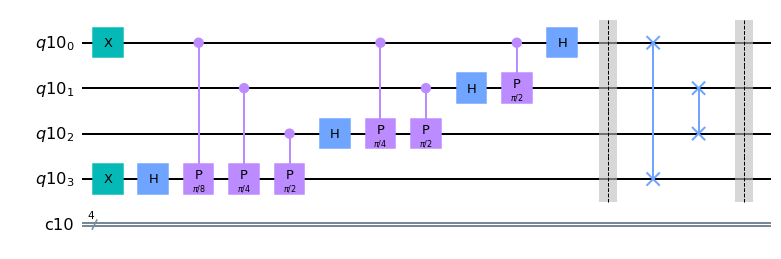

In [23]:
cr = ClassicalRegister(4)
qr = QuantumRegister(4)
test_QFT = QuantumCircuit(qr, cr)

test_QFT.x((0, 3))
test_QFT.barrier

QFT(test_QFT, 4)
test_QFT.barrier()

test_QFT.draw(output = 'mpl')

In [ ]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(test_QFT)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

And here is similarly implemented a function for inverse quantum fourier transform on a circuit.

In [ ]:
#As it will be used in the Phase Estimation, I define the QFT_dagger function.
def QFT_dagger(circ, n):
    #First we swap the registers, since the rest of the QFT_dagger returns
    #an "inverse" state
    for i in np.arange(n//2):
        #
        circ.swap(i, n-1-i)
    
    #We then apply the relevant Hadamard and phase gates.
    for i in np.arange(n):
        for j in np.arange(i):
            circ.cp(-np.pi/2**(i-j), j, i)
        circ.h(i)

    return circ

In [ ]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(test_QFT)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Before defining the phase estimation, I define the trotter decomposition used in the phase estimation, to allow me to calculate the phase of my unitary U. I define 3 functions that together are supposed to decompose a 2^N by 2^N Hermitian matrix into a sum of pauli vectors and thereafter apply it to the circuit via trotter decomposition

The first function, pauli_traces is the one that calculates how much of each pauli product is supposed to be used in the implementation of the Hamiltonian.

The second function is the one that applies one of the pauli products to the circuit, with an appropriate phase from pauli_traces.

The third function is the one 

In [ ]:
#This is the function that calculates the traces of a given hamiltonian
def pauli_traces(H):
    n = np.log2(H.shape[0]) 
    
    #First I define the array that will contain my multiplication
    IXYZ = np.zeros((4, 2, 2), dtype = "complex")
    
    #This segment defines the different  pauli gates in my base trace array.
    IXYZ[0] = np.array([[1, 0], [0, 1]])
    IXYZ[1] = np.array([[0, 1], [1, 0]])
    IXYZ[2] = np.array([[0, -1j], [1j, 0]])
    IXYZ[3] = np.array([[1, 0], [0, -1]])

    #Here I first define the "n = 0 case", so that for each I get the
    #right kronecker product for each iteration.
    tensors = np.array([[[1]]])
    
    #I calculate all the possible configurations of the tensor product.
    for i in np.arange(n):
        tensors = np.asarray([np.kron(i, j) for i in IXYZ for j in tensors])
    
    #The trace of tensors and H is then calculated, alongside the normalization factor.
    traces = [np.trace(np.dot(i, H)) for i in tensors]/(2**n)
    
    return traces.real

#This code applies 1 gate product as a time evolution for time segment t.
def exp_product(circ, trace, comb, p, control, t):
    #We check if the trace is 0, ie if the gate combination.
    #attributes to the sum. If not, we return.
    if abs(trace) == 0:
        return
    
    #Defining the reg number here, so we can loop over it later.
    reg = p
    
    #For each combination, we apply the appropriate gates,
    #albeit none for the I gate.
    for i in comb:
        if i == 1:
            circ.h(reg)
            circ.cx(reg, -1)
        elif i == 2:
            circ.u(np.pi/2, np.pi, np.pi, reg)
            circ.cx(reg, -1)
        elif i == 3:
            circ.cx(reg, -1)
        reg += 1
    
    #We simply apply the rx gate here, ressetting the register count.
    #The phase theta = -2t*trace is there to leave us with the appropriate
    #phase based on the rx gates base setup.
    circ.crz(-2*t*trace, control, -1)
    reg = p
    
    #Same as before, but here we apply the rotation after the CNOT's.
    for i in comb:
        if i == 1:
            circ.cx(reg, -1)
            circ.h(reg)
        elif i == 2:
            circ.cx(reg, -1)
            circ.u(np.pi/2, np.pi, np.pi, reg)
        elif i == 3:
            circ.cx(reg, -1)
        reg += 1
    
    circ.barrier()

#This function combines the trace and exp_product functions,
#to fully decompose the matrix H into gates on a circuit.
def decomposer(circ, H, p = 0, control = 0, r = 1, t = 1):
    n = int(np.log2(H.shape[0]))
    
    #First I find all possible combinations of gates, combs.
    combs = np.asarray(list(it.product(np.arange(4), repeat = n)))
    
    #I then calculate the traces, so that they are ready.
    #Since the crz gate doesn't take a complex phase, we need
    #to convert the complex values into real values, so that
    #it aligns with the simulation method.
    traces = pauli_traces(H)
    
    
    #We loop over each combination, applying them only if trace=! 0.
    #real is used here, since we can't use the complex type
    #for the rx gate.
    for rep in np.arange(r):
        for i in np.arange(4**n):
            exp_product(circ, traces[i], combs[i], p, control, t/r)
    circ.barrier()

In [ ]:
cr = ClassicalRegister(4)
qr = QuantumRegister(4)
test_QFT = QuantumCircuit(qr, cr)

test_QFT.x((0, 3))
test_QFT.barrier

QFT(test_QFT, 4)
QFT_dagger(test_QFT, 4)
test_QFT.barrier()

test_QFT.draw(output = 'mpl')

Then we use the decomposer code to apply the controlled U as part of our QPE algorithm.

In [ ]:
#This function runs phase estimation for our time evolution U,
#which is given by the function decomposer
def PhaseEst(circ, H, r, t, p):
    #First we apply a hadamard transformation to the first n qubits, serving as our QFT.
    circ.h(np.arange(p))
    
    #We now repeat CU on register_j, 2^j times.
    for reg in np.arange(p):
        for i in np.arange(2**reg):
            decomposer(circ, H, p, reg, r, t)
    
    #Lastly, we return to the computational basis by using the QFT_dagger function
    circ.barrier()
    circ = QFT_dagger(circ, p)
    
    return circ

Here we run the code for a sample Hamiltonian h.

First I define the sample 2-local Hamiltonian.

In [ ]:
h = np.array([[1, 0], [0, np.exp(-1j*np.pi/4)]])
h_temp = np.array([[1, 1], [1, -1]])

And  here we run the simulation

In [ ]:
p = 10
n = 1
epsilon = 0.1
t = 1
r = int(np.ceil(t**2/epsilon))
print(r)

cr = ClassicalRegister(p)
qr = QuantumRegister(p)
anc = QuantumRegister(n + 1)
test_FE = QuantumCircuit(qr, anc, cr)

#First we prepare the eigenstate we wish to investigate for.
test_FE.x(anc[0])
#test_FE.x(anc[1])

#With the following setup of theta, phi and lam, we get a controlled T-gate.
PhaseEst(test_FE, h, r, t, p)

#We measure the first n registers
test_FE.barrier()
test_FE.measure(np.arange(p), np.arange(p))

#Enable this to see the circuit
#test_FE.draw(output = 'mpl')

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024  # how many time execute the algorithm
job = execute(test_FE, backend, shots=shots)
result = job.result()
counts = result.get_counts()
plot_histogram(counts, bar_labels=False)

Here I classically calculate the eigenvalues with numpy.linalg

In [ ]:
evals, _ = np.linalg.eig(h)
print(evals)

And we convert the most common bitstring into an estimated phase an compare it to the classically determined eigenvalues.

In [ ]:
phase_bits = max(counts, key=counts.get) # take the most often obtaned result

print('The most common bit is')
print(phase_bits)

phase = 0
for index, bit in enumerate((phase_bits)):
    phase += int(bit) / 2**(index + 1)

print(phase)
estimated = np.exp(2 * np.pi * 1j * phase / t)

# Print out the estimated eigenvalues
print("\nEigenvalue from QPE:")
print(estimated)

# Print out the actual eigenvalues
print("\nActual eigenvalues:")
print(set(sorted(evals, key=lambda x: abs(x)**2)))